# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.7 MB/s eta 0:00:

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:09<00:27,  9.18s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:15<00:14,  7.42s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:20<00:06,  6.56s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:26<00:00,  6.73s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:06<00:06,  3.05s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:10<00:03,  3.68s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [11]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [12]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [13]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:05<00:00,  5.03s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:05<00:00,  5.03s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [14]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [15]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Model Poisoning Attack
print("--- Defining Model Poisoning Attack ---")
num_malicious_clients = 3  # about 10% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]
poison_factor = 3.0 # Amplify weights to overpower other clients. A negative value could be used to flip the weights.

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Scaling weights by a factor of {poison_factor} for malicious clients after local training.")
print("--- Model Poisoning Attack Defined ---")


--- Defining Model Poisoning Attack ---
Poisoning 3 clients: ['0', '1', '2']
Scaling weights by a factor of 3.0 for malicious clients after local training.
--- Model Poisoning Attack Defined ---


In [20]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
6     12985
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  6 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8  0 33 26 22 12 21
  9 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
6     12985
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16    

Visualize Data Distribution

STRATIFIED Client

In [21]:
#STRATIFIED Client

In [22]:
#LEAVE_ONE_OUT

In [23]:
#Half begign

In [24]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


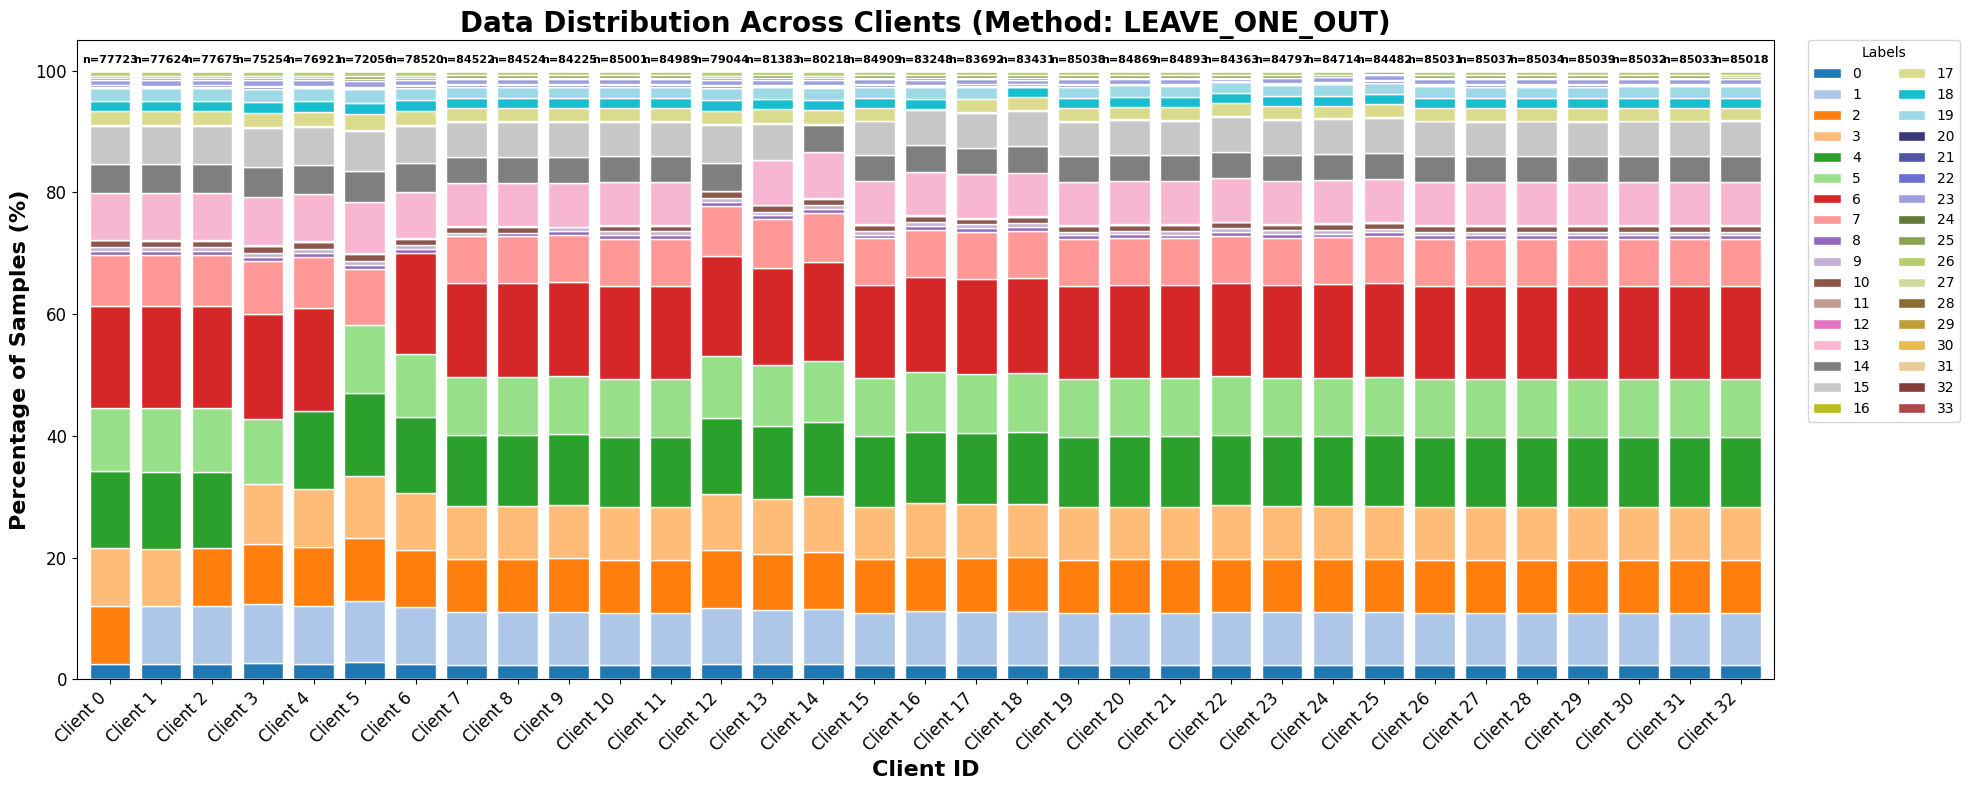

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [26]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [27]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [29]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [30]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [32]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")

        weights = self.model.get_weights()

        # If the client is in the malicious list, poison the weights
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying model poisoning...")
            poisoned_weights = [w * poison_factor for w in weights]
            return poisoned_weights, len(self.train_data), {}

        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [33]:
from flwr.server.strategy import FedAdagrad

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )

# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_OF_CLIENTS,
        initial_parameters=initial_parameters,
        evaluate_fn=get_evaluate_fn(server_model),
    )

# Define FedProx strategy
# strategy = FedProx(
#     proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
#     fraction_fit=1.0,  # Fraction of clients to sample for training
#     fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
#     min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
#     min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
#     min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
#     evaluate_fn=get_evaluate_fn(server_model),
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



2025-09-10 09:07:30,631	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7969033422.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3984516710.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Server Evaluating... Evaluation Count: 0
 4175/23275 ━━━━━━━━━━━━━━━━━━━━ 1:02 3ms/step - accuracy: 0.0111 - loss: 3.5547

(pid=1839) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1839) E0000 00:00:1757495277.348190    1839 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1839) E0000 00:00:1757495277.364860    1839 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1839) W0000 00:00:1757495277.415602    1839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1839) W0000 00:00:1757495277.415665    1839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1839) W0000 00:00:1757495277.415672    1839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

23275/23275 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.0111 - loss: 3.5542
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.5552279949188232, {'accuracy': 0.010946709662675858}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


Prediction:  [[0.01909399 0.03142988 0.01577437 ... 0.04118536 0.01526841 0.01850646]
 [0.02589747 0.03904747 0.03648484 ... 0.02527909 0.01937864 0.01509674]
 [0.03212114 0.03241613 0.02128887 ... 0.03036292 0.01500012 0.05077308]
 ...
 [0.01569269 0.08164111 0.00680512 ... 0.02359343 0.01030092 0.01176204]
 [0.0294222  0.0298058  0.02972509 ... 0.02333884 0.02949131 0.02193201]
 [0.02937957 0.03160051 0.03074549 ... 0.02495874 0.02886422 0.02390651]] (744790, 34)
Server evaluation complete - Accuracy: 0.0109, Loss: 3.5552
(ClientAppActor pid=1840) Client ID: 26


(ClientAppActor pid=1840) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1840) 
(ClientAppActor pid=1840)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1840)             entirely in future versions of Flower.
(ClientAppActor pid=1840)         
(ClientAppActor pid=1840) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1840)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(pid=1840) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1840) E0000 0

(ClientAppActor pid=1840) Client  26 Training...


(ClientAppActor pid=1840) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)         


  15/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0660 - loss: 3.4399    
  34/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1363 - loss: 3.3231
  55/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1983 - loss: 3.2013
  73/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2463 - loss: 3.0954
  92/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2875 - loss: 2.9856
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:55:52 3s/step - accuracy: 0.0000e+00 - loss: 3.5260
 104/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3093 - loss: 2.9173
  16/2658 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.0872 - loss: 3.4098
 119/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3329 - loss: 2.8346
 172/2658 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3873 - loss: 2.5825
(ClientAppActor pid=1839) Client ID: 30
(ClientAppActor pid=1839) Client  30 Training...
 916/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6011 - loss: 1.3773
 946/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step -

(ClientAppActor pid=1840) 
(ClientAppActor pid=1840)         
(ClientAppActor pid=1840) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1840)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1840)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1840) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1840)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

   1/2429 ━━━━━━━━━━━━━━━━━━━━ 1:14:25 2s/step - accuracy: 0.0000e+00 - loss: 3.5485
  32/2429 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1271 - loss: 3.4139
 232/2429 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4294 - loss: 2.3711 [repeated 32x across cluster]
 175/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3970 - loss: 2.5449 [repeated 7x across cluster]
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6654 - loss: 0.9481 [repeated 5x across cluster]
 197/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4154 - loss: 2.4498
 224/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4349 - loss: 2.3453
(ClientAppActor pid=1839) Client  30 Training complete...
(ClientAppActor pid=1839) Client ID: 16
(ClientAppActor pid=1839) Client  16 Training...
 463/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5356 - loss: 1.7774
 487/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5419 - loss: 1.7412
 523/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0

(ClientAppActor pid=1840) 
(ClientAppActor pid=1840)         
(ClientAppActor pid=1840) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1840)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1840)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1840) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1840)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

   1/2637 ━━━━━━━━━━━━━━━━━━━━ 1:21:32 2s/step - accuracy: 0.0312 - loss: 3.5544
  29/2637 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1167 - loss: 3.3880
 604/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5635 - loss: 1.6249 [repeated 53x across cluster]
 762/2637 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5880 - loss: 1.4611
(ClientAppActor pid=1839) Client  16 Training complete...
(ClientAppActor pid=1839) Client ID: 21
(ClientAppActor pid=1839) Client  21 Training...
1095/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6170 - loss: 1.2828
1176/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6225 - loss: 1.2481
1210/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6246 - loss: 1.2346
1251/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6270 - loss: 1.2190
   1/2653 ━━━━━━━━━━━━━━━━━━━━ 1:10:29 2s/step - accuracy: 0.0312 - loss: 3.4626
  30/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1146 - loss: 3.3673
1650/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - 

(ClientAppActor pid=1840) 
(ClientAppActor pid=1840)         
(ClientAppActor pid=1840) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1840)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1840)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1840) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1840)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

  17/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0951 - loss: 3.4194        
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6719 - loss: 0.9342 [repeated 84x across cluster]
   1/2616 ━━━━━━━━━━━━━━━━━━━━ 1:09:31 2s/step - accuracy: 0.0312 - loss: 3.4612
  32/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1352 - loss: 3.3216
 169/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4244 - loss: 2.5257 [repeated 2x across cluster]
 290/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5130 - loss: 2.0818
(ClientAppActor pid=1839) Client  21 Training complete...
(ClientAppActor pid=1839) Client ID: 17
(ClientAppActor pid=1839) Client  17 Training...
1136/2454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6692 - loss: 1.1765
1491/2616 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6518 - loss: 1.1052 [repeated 87x across cluster]
1587/2616 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6558 - loss: 1.0803 [repeated 10x across cluster]
1629/2616 ━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1840) 
(ClientAppActor pid=1840)         
(ClientAppActor pid=1840) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1840)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1840)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1840) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1840)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

  27/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1353 - loss: 3.3951      
1472/2252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5929 - loss: 1.2349 [repeated 44x across cluster]
1042/2252 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5682 - loss: 1.3906 [repeated 3x across cluster]
(ClientAppActor pid=1839) Client  17 Training complete...


INFO :      aggregate_fit: received 9 results and 0 failures


(ClientAppActor pid=1840) Client  5 Training complete...
Server Evaluating... Evaluation Count: 1
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.6709 - loss: 0.9574
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.08377993e-04 8.89394723e-05 1.69876352e-04 ... 2.54662213e-04
  2.13676321e-05 8.46845651e-05]
 [1.07115069e-04 4.31820117e-05 9.94416058e-01 ... 6.14952878e-05
  2.52938889e-06 6.88548107e-06]
 [2.59455619e-03 5.31404326e-03 6.42975094e-03 ... 2.57129082e-03
  1.27427847e-04 3.34353074e-02]
 ...
 [5.03281422e-04 3.64989137e-05 4.23885271e-04 ... 3.75095915e-05
  1.14442091e-05 1.22046069e-04]
 [9.96868219e-03 7.12550571e-03 6.44822465e-03 ... 1.04863627e-03
  3.25436122e-04 6.07562892e-04]
 [1.16800293e-02 8.00823607e-03 1.13573475e-02 ... 1.40620384e-03
  4.11355839e-04 8.20689951e-04]] (744790, 34)


INFO :      fit progress: (1, 0.958563506603241, {'accuracy': 0.6707541942596436}, 201.052710724)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.6708, Loss: 0.9586


(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1839) Client ID: 17
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6175 - loss: 1.0781 [repeated 15x across cluster]
(ClientAppActor pid=1839) Client  17 Evaluating...


(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

  22/2616 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6328 - loss: 1.0304    
 508/2616 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6733 - loss: 0.9560
 926/2616 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6769 - loss: 0.9481 [repeated 21x across cluster]


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


(ClientAppActor pid=1839) Client 17 evaluation complete - Accuracy: 0.682156, Loss: 0.933327
(ClientAppActor pid=1839) Client ID: 25


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1839) Client  25 Training...


(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

  28/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7110 - loss: 0.7912    
2616/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6798 - loss: 0.9405 [repeated 36x across cluster]
 520/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7263 - loss: 0.6111


(raylet) [2025-09-10 09:13:30,634 E 1655 1655] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e5d574be98b106b3d21fa37788d5e911f7451c398f5014a781a0f520, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


2563/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7337 - loss: 0.5493 [repeated 49x across cluster]


INFO :      aggregate_fit: received 1 results and 8 failures


Server Evaluating... Evaluation Count: 2
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7339 - loss: 0.5485
(ClientAppActor pid=1839) Client  25 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7257 - loss: 0.5940
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[3.5521171e-05 4.6713969e-05 8.9975889e-05 ... 6.0803446e-05
  7.2064195e-06 4.8734368e-05]
 [8.7869748e-06 5.2253930e-05 9.9686968e-01 ... 2.0227020e-05
  2.7861822e-07 2.2350453e-06]
 [1.3590148e-05 3.6458857e-04 3.9472643e-04 ... 1.7394335e-05
  7.7767913e-07 9.5455186e-04]
 ...
 [1.4278359e-05 7.3077940e-06 2.2588469e-05 ... 3.4935742e-06
  6.6131133e-06 1.7142955e-05]
 [5.4121920e-04 1.0014867e-03 1.1155171e-03 ... 4.3361892e-05
  1.7488255e-05 1.0191625e-04]
 [6.7491055e-04 1.6270472e-03 2.2696385e-03 ... 7.5186334e-05
  2.8241326e-05 1.9149162e-04]] (744790, 34)


INFO :      fit progress: (2, 0.5946153402328491, {'accuracy': 0.7252755761146545}, 352.55041846899996)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.7253, Loss: 0.5946
(ClientAppActor pid=1839) Client ID: 23
2634/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7339 - loss: 0.5485 [repeated 2x across cluster]


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1839) Client  23 Evaluating...


(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2650 ━━━━━━━━━━━━━━━━━━━━ 1:04:29 1s/step - accuracy: 0.8438 - loss: 0.4759
  10/2650 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7560 - loss: 0.5729 
  47/2650 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7474 - loss: 0.5902
 106/2650 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7389 - loss: 0.5879 
 365/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7337 - loss: 0.5788
 849/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7319 - loss: 0.5811
1038/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7313 - loss: 0.5818 [repeated 25x across cluster]
1129/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7310 - loss: 0.5823
1803/2650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7293 - loss: 0.5838
2392/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7286 - loss: 0.5846 [repeated 47x across cluster]


INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2650/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7284 - loss: 0.5849
(ClientAppActor pid=1839) Client 23 evaluation complete - Accuracy: 0.726299, Loss: 0.587789


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_t

(ClientAppActor pid=1839) Client ID: 15


(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1839) Client  15 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2654 ━━━━━━━━━━━━━━━━━━━━ 1:52:50 3s/step - accuracy: 0.8438 - loss: 0.4915
  53/2654 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7413 - loss: 0.5834
 162/2654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7355 - loss: 0.5800 [repeated 11x across cluster]
 503/2654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7379 - loss: 0.5527
2148/2654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7411 - loss: 0.5269


INFO :      aggregate_fit: received 1 results and 8 failures


Server Evaluating... Evaluation Count: 3
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7416 - loss: 0.5241
(ClientAppActor pid=1839) Client  15 Training complete...
2651/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7416 - loss: 0.5242 [repeated 48x across cluster]
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.7416 - loss: 0.5322
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[7.3378537e-06 1.6324608e-05 2.8868653e-05 ... 9.3282915e-06
  1.0241818e-06 3.4819802e-06]
 [6.8983496e-07 1.2692382e-05 9.9904948e-01 ... 8.1316767e-07
  1.4300152e-09 1.3808533e-07]
 [5.2291366e-06 3.0167762e-04 1.9634112e-04 ... 1.3232137e-06
  4.5955083e-08 1.6168997e-04]
 ...
 [3.8800154e-06 1.6584644e-06 1.2064752e-05 ... 2.1077973e-07
  3.8535140e-07 3.6262679e-07]
 [2.3143721e-04 2.2140049e-04 3.0563775e-04 ... 8.2728120e-06
  1.3261390e-06 2.4879826e-05]
 [2.8138276e-04 4.5958947e-04 6.6605140e-04 ... 1.3218723e-05
  1.9359027e-06 5.1990301e-05]] (744790, 34)


INFO :      fit progress: (3, 0.5319209694862366, {'accuracy': 0.7415647506713867}, 497.65232294300006)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.7416, Loss: 0.5319
(ClientAppActor pid=1839) Client ID: 21
(ClientAppActor pid=1839) Client  21 Evaluating...


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/2653 ━━━━━━━━━━━━━━━━━━━━ 2:19:03 3s/step - accuracy: 0.6875 - loss: 0.6123
  39/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7188 - loss: 0.5331
  79/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7340 - loss: 0.5195
 113/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7380 - loss: 0.5171
 156/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7406 - loss: 0.5162
 201/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7421 - loss: 0.5167
 238/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7427 - loss: 0.5176
 263/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7429 - loss: 0.5183
 305/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7434 - loss: 0.5187
 348/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7435 - loss: 0.5192
 397/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7437 - loss: 0.5198
 434/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7438 - loss: 0.5202
 473/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7440 - loss: 0.

INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2538/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 0.5254
2603/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7436 - loss: 0.5255
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7436 - loss: 0.5256
(ClientAppActor pid=1839) Client 21 evaluation complete - Accuracy: 0.742806, Loss: 0.527610
(ClientAppActor pid=1839) Client ID: 29
(ClientAppActor pid=1839) Client  29 Training...


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:36:36 2s/step - accuracy: 0.7812 - loss: 0.4664
  55/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7420 - loss: 0.5372
 111/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7407 - loss: 0.5325
 163/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7398 - loss: 0.5308
 218/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7401 - loss: 0.5289
 269/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7404 - loss: 0.5274
 324/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7401 - loss: 0.5265
 373/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7398 - loss: 0.5257
 386/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7397 - loss: 0.5254
 414/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7396 - loss: 0.5247
 453/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7397 - loss: 0.5236
 503/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7398 - loss: 0.5224
 553/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7400 - loss: 0.

INFO :      aggregate_fit: received 1 results and 8 failures


2636/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.5088
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7429 - loss: 0.5087
(ClientAppActor pid=1839) Client  29 Training complete...
Server Evaluating... Evaluation Count: 4
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.7435 - loss: 0.5248
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[4.96568055e-06 1.41849077e-05 2.79417964e-05 ... 5.02632793e-06
  4.40745993e-07 1.21130915e-06]
 [1.98833703e-07 6.79459276e-07 9.99569595e-01 ... 8.95574672e-08
  1.52564891e-10 3.05232106e-08]
 [2.06375626e-06 1.79819923e-04 1.10533525e-04 ... 1.37182369e-07
  7.04687420e-09 1.69182094e-05]
 ...
 [1.01155354e-06 6.50453899e-07 1.23009045e-06 ... 1.64267604e-08
  4.70651855e-08 6.69575755e-08]
 [9.59881218e-05 6.41630031e-05 1.46553240e-04 ... 1.60129559e-06
  3.97402147e-07 6.59647731e-06]
 [1.00922589e-04 1.27944120e-04 3.79841891e-04 ... 2.09716995e-06
  5.08676578e-07 1.19282677e-05]] (744790,

INFO :      fit progress: (4, 0.5244203209877014, {'accuracy': 0.7438875436782837}, 611.630081198)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.7439, Loss: 0.5244
(ClientAppActor pid=1839) Client ID: 23
(ClientAppActor pid=1839) Client  23 Evaluating...


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   4/2650 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.7663 - loss: 0.5568  
  13/2650 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7524 - loss: 0.5552
  44/2650 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7513 - loss: 0.5352
  73/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7524 - loss: 0.5255
 115/2650 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7500 - loss: 0.5231
 150/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7485 - loss: 0.5216 
 187/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7482 - loss: 0.5197
 226/2650 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7481 - loss: 0.5181
 259/2650 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7481 - loss: 0.5169
 295/2650 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7483 - loss: 0.5159
 330/2650 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7485 - loss: 0.5153
 368/2650 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7487 - loss: 0.5147
 410/2650 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7489 - lo

INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 9 clients (out of 33)


2577/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7468 - loss: 0.5166
2637/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7467 - loss: 0.5166
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7467 - loss: 0.5166
(ClientAppActor pid=1839) Client 23 evaluation complete - Accuracy: 0.745121, Loss: 0.518853
(ClientAppActor pid=1839) Client ID: 23


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1839) Client  23 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  27/2650 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6963 - loss: 0.5701    
  80/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7119 - loss: 0.5367
 132/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7220 - loss: 0.5218
 174/2650 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7262 - loss: 0.5155
 227/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7292 - loss: 0.5115
 276/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7311 - loss: 0.5092
 328/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7326 - loss: 0.5074
 378/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7338 - loss: 0.5060
 424/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7349 - loss: 0.5046
 476/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7360 - loss: 0.5033
 524/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7370 - loss: 0.5024
 577/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7379 - loss: 0.5016
 624/2650 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7385 - loss: 0.

INFO :      aggregate_fit: received 1 results and 8 failures


2610/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7429 - loss: 0.4953
2647/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7430 - loss: 0.4953
Server Evaluating... Evaluation Count: 5
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7430 - loss: 0.4953
(ClientAppActor pid=1839) Client  23 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.7411 - loss: 0.5052
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[1.33442893e-06 9.37804816e-06 1.02803015e-05 ... 2.01359626e-06
  1.62832976e-07 2.52690313e-07]
 [4.77464042e-08 6.77571165e-07 9.98824537e-01 ... 3.47865416e-08
  3.09791255e-11 1.07987743e-08]
 [9.48160732e-07 9.30639580e-05 8.11438877e-05 ... 4.36831584e-08
  5.02692021e-09 5.24432426e-06]
 ...
 [1.89238719e-07 2.78887768e-07 4.71123116e-07 ... 3.53923246e-09
  2.09293525e-08 9.80694015e-09]
 [2.64033715e-05 1.72091404e-05 6.16978141e-05 ... 3.21619467e-07
  1.06681298e-07 2.21257665e-06]
 [2.96445614e-05 4.42672135e-05

INFO :      fit progress: (5, 0.5051727890968323, {'accuracy': 0.7409121990203857}, 768.009678888)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 33)


Server evaluation complete - Accuracy: 0.7409, Loss: 0.5052
(ClientAppActor pid=1839) Client ID: 5


(ClientAppActor pid=1839) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1839) 
(ClientAppActor pid=1839)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1839)             entirely in future versions of Flower.
(ClientAppActor pid=1839)         
(ClientAppActor pid=1839) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1839)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1839) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1839) Client  5 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   6/2252 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7189 - loss: 0.4999
  18/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7366 - loss: 0.5182 
  35/2252 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.7284 - loss: 0.5429
  74/2252 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7195 - loss: 0.5680
 121/2252 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7171 - loss: 0.5757 
 186/2252 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7152 - loss: 0.5815
 244/2252 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7130 - loss: 0.5842
 296/2252 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7113 - loss: 0.5854
 361/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7096 - loss: 0.5869
 424/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7081 - loss: 0.5881
 516/2252 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7066 - loss: 0.5893
 575/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7059 - loss: 0.5896
 642/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7052 - l

INFO :      aggregate_evaluate: received 1 results and 8 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 775.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.9333268404006958
INFO :      		round 2: 0.5877886414527893
INFO :      		round 3: 0.5276102423667908
INFO :      		round 4: 0.518852949142456
INFO :      		round 5: 0.5967752933502197
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.5552279949188232
INFO :      		round 1: 0.958563506603241
INFO :      		round 2: 0.5946153402328491
INFO :      		round 3: 0.5319209694862366
INFO :      		round 4: 0.5244203209877014
INFO :      		round 5: 0.5051727890968323
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.010946709662675858),
INFO :      	              (1, 0.6707541942596436),
INFO :      	              (2, 0.7252755761146545),
INFO :      	              (3, 0.7415647506713867),
INFO :      	              (4, 0.7438875436782837),
I

2224/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.5947
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6988 - loss: 0.5947
Total time taken:  0:15:26.906259
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


(ClientAppActor pid=1839) Client 5 evaluation complete - Accuracy: 0.695057, Loss: 0.596775


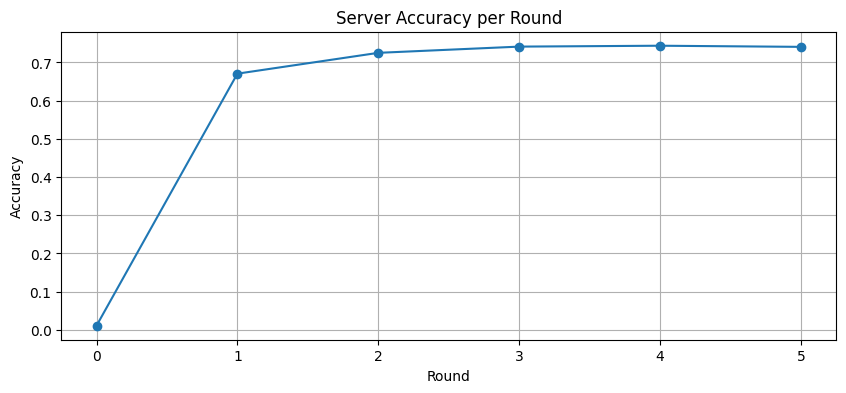

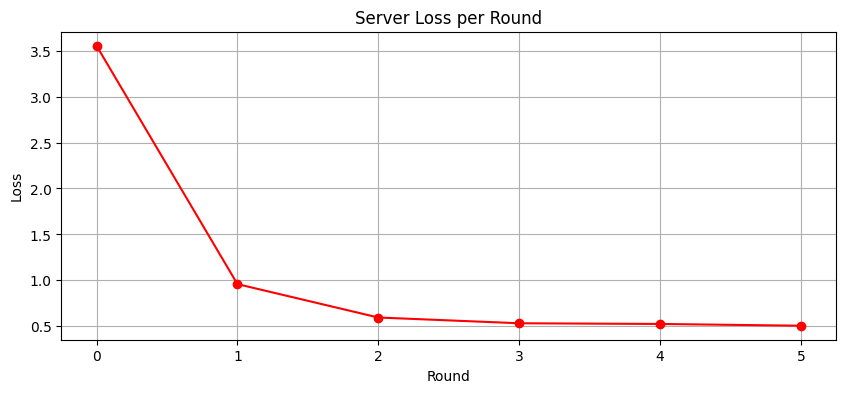

In [34]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()


2025-09-10 09:13:38.620775 - 0 : Server evaluation complete - Accuracy: 0.0083, Loss: 3.6590
2025-09-10 09:15:37.854556 - 1 : Server evaluation complete - Accuracy: 0.6653, Loss: 1.2641
2025-09-10 09:17:42.074396 - 2 : Server evaluation complete - Accuracy: 0.7451, Loss: 0.5455
2025-09-10 09:20:17.217937 - 3 : Server evaluation complete - Accuracy: 0.7255, Loss: 0.5040
2025-09-10 09:22:37.458198 - 4 : Server evaluation complete - Accuracy: 0.7316, Loss: 0.5000
2025-09-10 09:25:53.644811 - 5 : Server evaluation complete - Accuracy: 0.7529, Loss: 0.5136

```2025-09-10 09:13:38.620775 - 0 : Server evaluation complete - Accuracy: 0.0083, Loss: 3.6590
2025-09-10 09:15:37.854556 - 1 : Server evaluation complete - Accuracy: 0.6653, Loss: 1.2641
2025-09-10 09:17:42.074396 - 2 : Server evaluation complete - Accuracy: 0.7451, Loss: 0.5455
2025-09-10 09:20:17.217937 - 3 : Server evaluation complete - Accuracy: 0.7255, Loss: 0.5040
2025-09-10 09:22:37.458198 - 4 : Server evaluation complete - Accuracy: 0.7316, Loss: 0.5000
2025-09-10 09:25:53.644811 - 5 : Server evaluation complete - Accuracy: 0.7529, Loss: 0.5136

```





```
2025-09-10 09:13:38.620775 - 0 : Server evaluation complete - Accuracy: 0.0083, Loss: 3.6590
2025-09-10 09:15:37.854556 - 1 : Server evaluation complete - Accuracy: 0.6653, Loss: 1.2641
2025-09-10 09:17:42.074396 - 2 : Server evaluation complete - Accuracy: 0.7451, Loss: 0.5455
2025-09-10 09:20:17.217937 - 3 : Server evaluation complete - Accuracy: 0.7255, Loss: 0.5040
2025-09-10 09:22:37.458198 - 4 : Server evaluation complete - Accuracy: 0.7316, Loss: 0.5000
2025-09-10 09:25:53.644811 - 5 : Server evaluation complete - Accuracy: 0.7529, Loss: 0.5136

```

